<a id="sec-verif"></a>
## Verifying numerical rates of convergence <span class="toc-short" data-short-title="Numerical verification"></span>

Let’s explore the first application of PEP: numerically verifying the rate of convergence. As an illustrative example, we consider gradient descent (GD) on $L$-smooth convex functions. We look for the __worst__ function $f$ for which, after $N$ iterations of GD, the objective gap $f(x_N) - f(x_\star)$ is as large as possible, where $x_\star$ denotes a minimizer of $f$. In other words, we obtain the __worst-case__ convergence guarantee of GD by solving the following optimization problem 

```{math}
\begin{equation}
\begin{split}
\text{maximize} \quad & \text{some performance metric} && f(x_N) - f(x_\star) \\
\text{subject to} \quad & \text{$f$ belongs to some function class} && \text{$f$ is $L$-smooth convex} \\
& \text{$\{x_k\}_{k=1}^N$ is generated by an algorithm} \qquad \quad && x_{k+1} = x_k - \alpha \nabla f(x_k), \;\; k=0,\ldots,N-1 \\
& \text{$x_0$ satisfies some initial condition} && \|x_0 - x_\star\|^2 \leq R^2 \\
& \text{$x_\star$ is a minimizer of $f$} && \nabla f(x_\star) = 0.
\end{split} \qquad \;\; \tag{PEP}
\end{equation}
```

We start by setting up a `PEPContext` object in <span class="brand-color">PEPFlow</span>. This `PEPContext` object keeps track of all the mathematical objects such as points and scalars involved in the analysis.

In [ ]:
import pepflow as pf
import numpy as np
import matplotlib.pyplot as plt

ctx = pf.PEPContext("gd").set_as_current()

```{admonition} More on PEPContext
:class: dropdown pepflow-dropdown

The above cell not only creates a new `PEPContext` object called `ctx`, but it also sets the `ctx` object as the current working context. This means that all newly generated `Scalar` and `Vector` objects representing mathematical objects such as scalars and vectors/points will be automatically managed by `ctx`.

__NB__: In this tutorial, purple toggle lists provide extra details about the usage of <span class="brand-color">PEPFlow</span>. They are useful for deeper exploration or research, but can be skipped on a first read.

Then, we declare the four ingredients of algorithm analysis:
- <span style="font-weight:bold">function class</span>: $L$-smooth convex functions;
- <span style="font-weight:bold">algorithm of interest</span>: gradient descent method;
- <span style="font-weight:bold">initial condition</span>: initial point and optimum are not too far away $\|x_0 - x_\star\|^2 \leq R^2$;
- <span style="font-weight:bold">performance metric</span>: objective gap $f(x_k) - f(x_\star)$.

<span class="brand-color">PEPFlow</span> allows us to describe these objects in a high-level way that mirrors the mathematical setup. We first create a `PEPBuilder` object which hold all the information needed to construct and solve PEPs.

In [2]:
pep_builder = pf.PEPBuilder(ctx)

```{admonition} More on PEPBuilder
:class: dropdown pepflow-dropdown

A `PEPBuilder` object requires passing in a `PEPContext` object as an argument. Using the `Scalar` and `Vector` objects managed by the `PEPContext` object, we can define the performance metric and initial condition for the `PEPBuilder` object to store.

We now define an $L$-smooth convex function $f$ and set a stationary point called `x_star`.

In [3]:
L = pf.Parameter("L")

# Define function class
f = pf.SmoothConvexFunction(is_basis=True, tags=["f"], L=L)
x_star = f.set_stationary_point("x_star")

```{admonition} More on defining Function objects
:class: dropdown pepflow-dropdown

<span class="brand-color">PEPFlow</span> offers several types of functions classes such as `SmoothConvexFunction` and `ConvexFunction`. The `is_basis` argument takes a `boolean` that designates whether the created `Function` object is formed as a linear combination of other `Function` objects. The `tags` argument takes in a `list` of strings which can be used to access the `Function` object through the method `get_func_or_oper_by_tag`. The last element of the `tags` list will be used to display the `Function` object.

```{admonition} More on Parameter objects
:class: dropdown pepflow-dropdown

The `Parameter` objects can be thought of as mathematical variables. As we will see later on in the tutorial, when we perform specific operations such as solving the PEP problem, we will need to supply explicit values for the `Parameter` object.

```{admonition} More on tags
:class: dropdown pepflow-dropdown

Mathematical objects in <span class="brand-color">PEPFlow</span> contain a list of user-provided strings called `tags`. These tags are used to access the mathematical objects easily and to display the mathematical object cleanly. 

Now, we declare the initial condition $\lVert x_0 - x_\star \rVert^2 \leq R^2$.

In [4]:
R = pf.Parameter("R")

# Set the initial condition
x = pf.Vector(is_basis=True, tags=["x_0"])  # The first iterate
pep_builder.add_initial_constraint(
    ((x - x_star) ** 2).le(R**2, name="initial_condition")
)

```{admonition} More on Vector objects
:class: dropdown pepflow-dropdown

A `Vector` object represents an element of a pre-Hilbert space and is one of the key fundamental mathematical objects that <span class="brand-color">PEPFlow</span> provides. The `is_basis` argument takes a `boolean` that designates whether the created `Vector` object is formed as a linear combination of other `Vector` objects. The `tags` argument takes in a `list` of strings which can be used to access the `Vector` object easily from a context that manages it. The last element of the `tags` list will be used to display the `Vector` object.

```{admonition} More on ScalarConstraint objects
:class: dropdown pepflow-dropdown

The code `((x - x_star) ** 2).le(R**2, name="initial_condition")` creates a `ScalarConstraint` object which represent a scalar constraint used in the PEP. A `ScalarConstraint` object requires 4 components: 
- a `Scalar` object for the left hand side of the constraint;
- a `Scalar` object for the right hand side of the constraint;
- the type of constraint, _e.g._, (`le`, `geq`, `eq`);
- a user-provided name for the constraint.

Next, we define generate the GD iterates $\{x_i\}_{i=1}^{N}$. Note that for each iterate $x_i$ we add a tag to display it nicely and for easy access from the `PEPContext` object which tracks it. Furthermore, the `Vector` object representing $\nabla f(x)$ can be generated by calling `f.grad(x)`.

In [5]:
N = 8
alpha = 1 / L

# Define the gradient descent method
for i in range(N):
    x = x - alpha * f.grad(x)
    x.add_tag(f"x_{i + 1}")

```{admonition} Tags for composite Vectors and Scalars
:class: dropdown pepflow-dropdown

`Vector` and `Scalar` objects formed as linear combinations of basis objects do not have any tags. The GD iterates generated by the line of code `x = x - alpha * f.grad(x)` are examples of composite `Vector` objects. It is important for the user to give these composite objects tags to access these objects easily from the `PEPContext` that manages them.

Finally, we set the performance metric $f(x_k) - f(x_\star)$. Observe that the `Scalar` object representing $f(x)$ can be generated by calling `f(x)`. 

In [6]:
# Set the performance metric
x_N = ctx[f"x_{N}"]
pep_builder.set_performance_metric(f(x_N) - f(x_star))

```{admonition} Accessing Vector and Scalar objects from a PEPContext
:class: dropdown pepflow-dropdown

The `Vector` and `Scalar` objects managed by a `PEPContext` object can be easily accessed through their tags. In the prior code block, we returned the iterate $x_N$ represented by a `Vector` object with the tag `x_N` managed by the `PEPContext` object `ctx` through the code: `ctx[f"x_{N}"]`. 

Solving the PEP numerically gives the worst-case value of the chosen performance metric. 

In [7]:
L_value = 1
R_value = 1
result = pep_builder.solve(resolve_parameters={"L": L_value, "R": R_value})
print(f"primal PEP optimal value = {result.opt_value:.4f}")

primal PEP optimal value = 0.0294


```{admonition} Resolving Parameter objects
:class: dropdown pepflow-dropdown

To solve the PEP problem represented by the `pep_builder` object, we need to resolve the `Parameter` objects `L` and `R` with concrete numerical values. To do this, we pass in a dictionary of the form: `{name_of_parameter: concrete_value}`.

In this example, the numerical result can be interpreted as: for all $1$-smooth convex functions $f$, $8$-step GD starting at $x_0$ with $\|x_0 - x_\star\|^2 \leq 1$ satisfies

$$f(x_8) - f(x_\star) \leq 0.0294.$$

To better understand how the error decreases with the number of iterations, we repeat the process for each $k = 1, 2, \dots, 7$. This gives us a sequence of numerical values that can be compared to the known analytical rate.

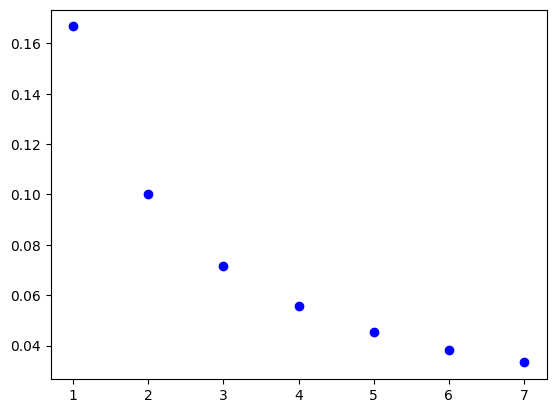

In [8]:
opt_values = []
for k in range(1, N):
    x_k = ctx[f"x_{k}"]
    pep_builder.set_performance_metric(f(x_k) - f(x_star))
    result = pep_builder.solve(resolve_parameters={"L": L_value, "R": R_value})
    opt_values.append(result.opt_value)

plt.scatter(range(1, N), opt_values, color="blue", marker="o");

The resulting values are visualized to show the trend of convergence. Each scatter point represents a guaranteed bound that holds for all $L$-smooth convex functions, while the continuous curve shows the known analytical rate for comparison (see, _e.g._, [^1]).

After experimenting with different $L$, $R$, and $N$, we tend to draw the conclusion: for all $L$-smooth convex functions $f$, $N$-step GD with step size $\alpha = 1/L$ satisfies

```{math}
f(x_N) - f(x_\star) \leq \frac{L}{4N+2} \|x_0 - x_\star\|_2^2.
```

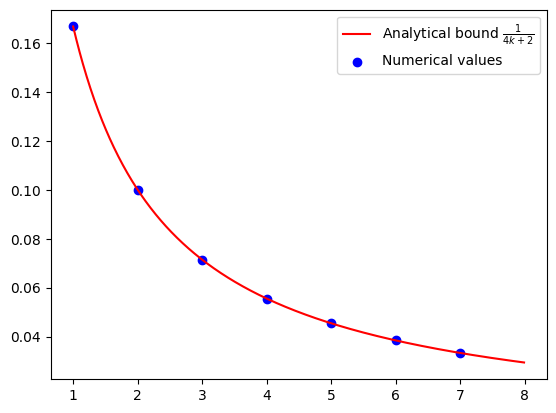

In [9]:
iters = np.arange(1, N)
cont_iters = np.arange(1, N, 0.01)
plt.plot(
    cont_iters,
    1 / (4 * cont_iters + 2),
    "r-",
    label="Analytical bound $\\frac{1}{4k+2}$",
)
plt.scatter(iters, opt_values, color="blue", marker="o", label="Numerical values")
plt.legend();

**References**

[^1]: Y. Drori and M. Teboulle. Performance of first-order methods for smooth convex minimization: a novel approach. _Mathematical Programming_, 145(1-2):451–482, 2014.